# Análisis Probabilístico de la EPH

Este notebook implementa un análisis probabilístico de los datos de la Encuesta Permanente de Hogares (EPH) del INDEC, Argentina.

## Objetivos
- Estudiar la relación entre nivel educativo y variables socioeconómicas
- Aplicar conceptos de probabilidad y distribuciones
- Generar visualizaciones interpretables

## Contenido
1. Carga y preparación de datos
2. Probabilidades simples
3. Probabilidades condicionales
4. Verificación de independencia
5. Teorema de Bayes
6. Modelado con distribuciones
7. Visualizaciones


In [1]:
# Importar bibliotecas necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Configuración de visualización
plt.style.use('seaborn')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

# Configurar visualización de datos en el notebook
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)
pd.set_option('display.float_format', lambda x: '%.3f' % x)


<ipython-input-1-3b87b11b7956>:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


## 1. Carga y Preparación de Datos

Primero cargaremos los datos desde los archivos Excel de la EPH y los prepararemos para el análisis.


In [2]:
import pandas as pd
HOGARES = pd.read_excel("usu_hogar_T324.xlsx")
PERSONAS = pd.read_excel("usu_individual_T324.xlsx")
CSV_COMPLETO = "base_completa_personas_hogares.csv"
CSV_FILTRADO = "base_pampeana_analizada.csv"
df_completo = pd.read_csv(CSV_COMPLETO)
df_filtrado = pd.read_csv(CSV_FILTRADO)




In [20]:
nivel_educ = {
        1: 'Primario incompleto',
        2: 'Primario completo',
        3: 'Secundario incompleto',
        4: 'Secundario completo',
        5: 'Superior universitario incompleto',
        6: 'Superior universitario completo',
        7: 'Sin instrucción',
        9: 'Ns/Nr'
    }
df_filtrado['nivel_educativo'] = df_filtrado['nivel_educativo'].map(nivel_educ)

regiones = {
        1: 'Gran Buenos Aires',
        40: 'NOA',
        41: 'NEA',
        42: 'Cuyo',
        43: 'Pampeana',
        44: 'Patagonia'
    }
df_filtrado['region'] = df_filtrado['region'].map(regiones)


ch04_map = {
    1: 'Varón',
    2: 'Mujer'
}
df_filtrado['sexo'] = df_filtrado['sexo'].map(ch04_map)

estado_map = {
    0: 'Entrevista individual no realizada',
    1: 'Ocupado',
    2: 'Desocupado',
    3: 'Inactivo',
    4: 'Menor de 10 años'
}
df_filtrado['estado_actividad'] = df_filtrado['estado_actividad'].map(estado_map)


# V14 - Han vivido...pedir préstamos a familiares/amigos? (Hogar - Estrategias) [12]
v14_map = {
    1: 'Sí',
    2: 'No'
}
df_filtrado['prestamo_personas'] = df_filtrado['prestamo_personas'].map(v14_map)

# V15 - Han vivido...pedir préstamos a bancos/financieras? (Hogar - Estrategias) [12]
v15_map = {
    1: 'Sí',
    2: 'No'
}
df_filtrado['prestamo_banco'] = df_filtrado['prestamo_banco'].map(v15_map)


# V16 - ¿Compran en cuotas o al fiado? (Hogar - Estrategias) [13]
v16_map = {
    1: 'Sí',
    2: 'No'
}
df_filtrado['compra_cuotas'] = df_filtrado['compra_cuotas'].map(v16_map)

df_filtrado['ingreso'] = df_filtrado['ingreso'].astype(int)


df_filtrado.loc[df_filtrado['fecha_nacimiento']=='2962-03-26 00:00:00','fecha_nacimiento']= '1962-03-26 00:00:00'
df_filtrado.loc[df_filtrado['fecha_nacimiento']=='9999-09-09 00:00:00','fecha_nacimiento']= '1999-09-09 00:00:00'
df_filtrado['fecha_nacimiento'] = pd.to_datetime(df_filtrado['fecha_nacimiento']).dt.date

In [21]:
df_filtrado.head(4)
for i in df_filtrado.columns:
    print(i)
    print(df_filtrado[i].unique())

id_vivienda
['TQRMNOQPRHKLKNCDEFJAH00868631' 'TQRMNORVXHKLKNCDEFJAH00868632'
 'TQRMNORQRHLMLLCDEGKDB00805055' ... 'TQRMNORUTHJOKOCDEFLID00866811'
 'TQTMNOUVSHMOLTCDEFKID00871192' 'TQRMNOSSTHLMMLCDEFKID00803746']
id_hogar
[1 2 3 4]
region
['Pampeana']
sexo
['Varón' 'Mujer']
fecha_nacimiento
[datetime.date(1943, 4, 22) datetime.date(1945, 9, 28)
 datetime.date(1958, 12, 28) ... datetime.date(1948, 8, 9)
 datetime.date(1969, 10, 29) datetime.date(1951, 11, 2)]
edad
[ 81  78  65  66  30  75  28  32  38  37  39  18  45  57  64  67  68  40
  62  77  29  31  69  54  56  72  63  27  49  92  21  42  82  20  46  58
  41  44  53  74  70  85  48  50  22  88  33  60  34  79  43  76  35  83
  47  23  24  80  52  25  19  73  61  51  36  26  55  59  87  96  84  71
  89  93  94  86  98  95  90  91 102]
estado_actividad
['Ocupado' 'Inactivo' 'Desocupado']
nivel_educativo
['Superior universitario completo' 'Secundario completo'
 'Superior universitario incompleto' 'Secundario incompleto'
 'Primario compl

In [22]:
datos = df_filtrado

## 2. Probabilidades Simples

Calculamos probabilidades empíricas simples para eventos de interés:
- Nivel educativo y estado de actividad
- Acceso a crédito y servicios financieros
- Distribución regional y por sexo

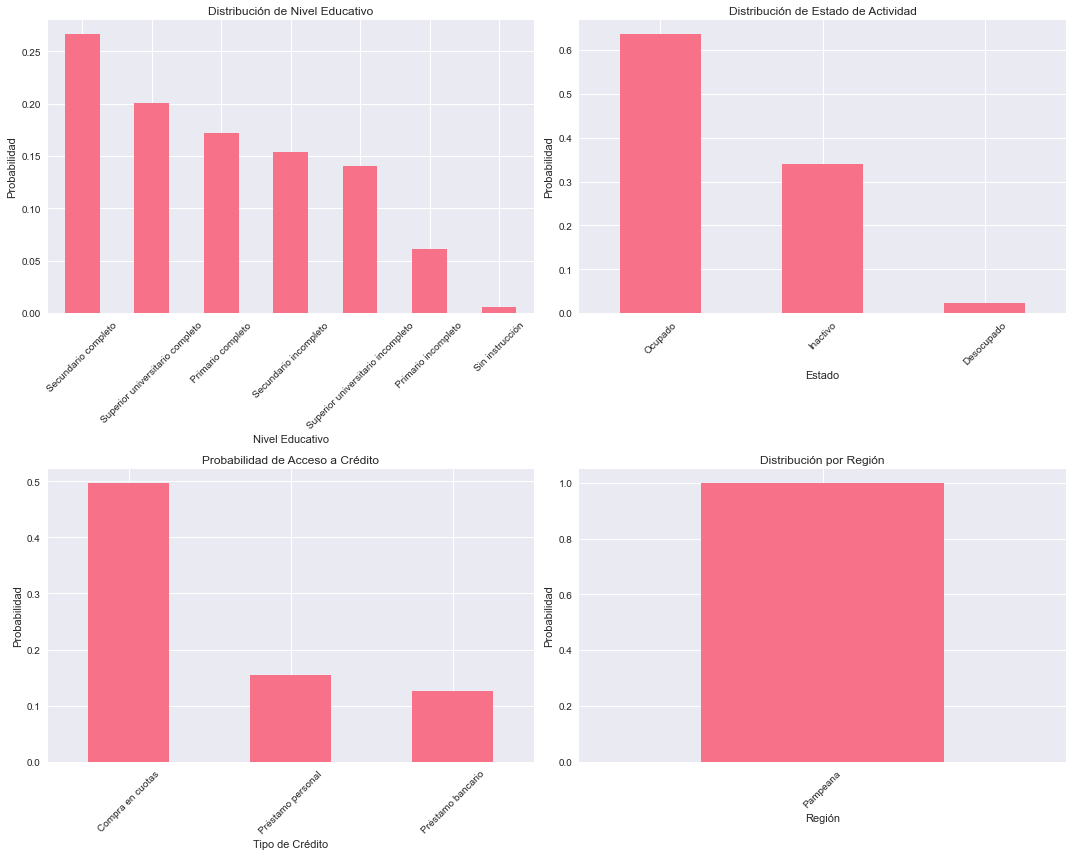

Probabilidades por nivel educativo:
nivel_educativo
Secundario completo                  26.6%
Superior universitario completo      20.0%
Primario completo                    17.2%
Secundario incompleto                15.4%
Superior universitario incompleto    14.1%
Primario incompleto                   6.1%
Sin instrucción                       0.6%
Name: proportion, dtype: object

Probabilidades por estado de actividad:
estado_actividad
Ocupado       63.6%
Inactivo      34.1%
Desocupado     2.3%
Name: proportion, dtype: object

Probabilidades de acceso a crédito:
Compra en cuotas: 49.7%
Préstamo personal: 15.5%
Préstamo bancario: 12.6%

Probabilidades por región:
region
Pampeana    100.0%
Name: proportion, dtype: object

P(Universitario ∩ Desocupado): 0.2%


In [23]:
# Probabilidades simples
def calcular_probabilidades_simples(datos):
    resultados = {}
    
    # P(Nivel educativo)
    resultados['p_nivel_educ'] = datos['nivel_educativo'].value_counts(normalize=True)
    
    # P(Estado de actividad)
    resultados['p_estado_act'] = datos['estado_actividad'].value_counts(normalize=True)
    
    # P(Acceso a crédito)
    resultados['p_credito'] = {
        'Compra en cuotas': (datos['compra_cuotas'] == 'Sí').mean(),
        'Préstamo personal': (datos['prestamo_personas'] == 'Sí').mean(),
        'Préstamo bancario': (datos['prestamo_banco'] == 'Sí').mean()
    }
    
    # P(Región)
    resultados['p_region'] = datos['region'].value_counts(normalize=True)
    
    # P(Universitario Y Desocupado)
    resultados['p_univ_desoc'] = ((datos['nivel_educativo'] == 'Superior universitario completo') & 
                                 (datos['estado_actividad'] == 'Desocupado')).mean()
    
    return resultados

# Calcular probabilidades
prob_simples = calcular_probabilidades_simples(datos)

# Crear visualizaciones
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# 1. Nivel educativo
prob_simples['p_nivel_educ'].plot(kind='bar', ax=ax1)
ax1.set_title('Distribución de Nivel Educativo')
ax1.set_xlabel('Nivel Educativo')
ax1.set_ylabel('Probabilidad')
ax1.tick_params(axis='x', rotation=45)

# 2. Estado de actividad
prob_simples['p_estado_act'].plot(kind='bar', ax=ax2)
ax2.set_title('Distribución de Estado de Actividad')
ax2.set_xlabel('Estado')
ax2.set_ylabel('Probabilidad')
ax2.tick_params(axis='x', rotation=45)

# 3. Acceso a crédito
pd.Series(prob_simples['p_credito']).plot(kind='bar', ax=ax3)
ax3.set_title('Probabilidad de Acceso a Crédito')
ax3.set_xlabel('Tipo de Crédito')
ax3.set_ylabel('Probabilidad')
ax3.tick_params(axis='x', rotation=45)

# 4. Región
prob_simples['p_region'].plot(kind='bar', ax=ax4)
ax4.set_title('Distribución por Región')
ax4.set_xlabel('Región')
ax4.set_ylabel('Probabilidad')
ax4.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Mostrar resultados numéricos
print("Probabilidades por nivel educativo:")
print(prob_simples['p_nivel_educ'].apply(lambda x: f"{x:.1%}"))

print("\nProbabilidades por estado de actividad:")
print(prob_simples['p_estado_act'].apply(lambda x: f"{x:.1%}"))

print("\nProbabilidades de acceso a crédito:")
for tipo, prob in prob_simples['p_credito'].items():
    print(f"{tipo}: {prob:.1%}")

print("\nProbabilidades por región:")
print(prob_simples['p_region'].apply(lambda x: f"{x:.1%}"))

print(f"\nP(Universitario ∩ Desocupado): {prob_simples['p_univ_desoc']:.1%}")


## 3. Probabilidades Condicionales

Analizamos la relación entre variables calculando probabilidades condicionales:
- Estado de actividad dado el nivel educativo
- Acceso a crédito dado el nivel educativo y estado de actividad
- Diferencias por región y sexo



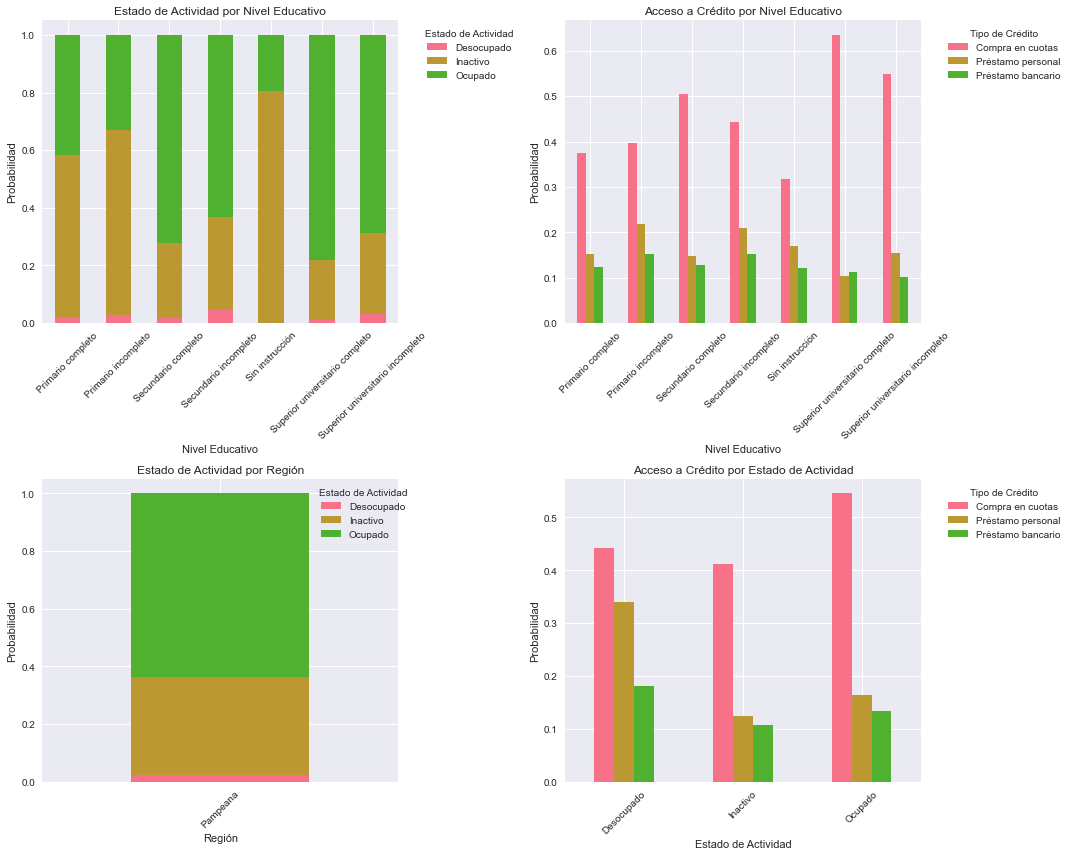

P(Estado de actividad | Nivel educativo superior completo):
estado_actividad
Desocupado     0.9%
Inactivo      21.1%
Ocupado       78.0%
Name: Superior universitario completo, dtype: object

P(Acceso a crédito | Ocupado):
Compra en cuotas: 54.6%
Préstamo personal: 16.5%
Préstamo bancario: 13.4%

P(Estado de actividad | Pampeana):
estado_actividad
Desocupado     2.3%
Inactivo      34.1%
Ocupado       63.6%
Name: Pampeana, dtype: object


In [24]:
# Probabilidades condicionales
def calcular_probabilidades_condicionales(datos):
    resultados = {}
    
    # P(Estado actividad | Nivel educativo)
    resultados['p_act_educ'] = pd.crosstab(
        datos['nivel_educativo'], 
        datos['estado_actividad'], 
        normalize='index'
    )
    
    # P(Acceso crédito | Nivel educativo)
    resultados['p_cred_educ'] = pd.DataFrame({
        'Compra en cuotas': datos.groupby('nivel_educativo')['compra_cuotas'].apply(lambda x: (x == 'Sí').mean()),
        'Préstamo personal': datos.groupby('nivel_educativo')['prestamo_personas'].apply(lambda x: (x == 'Sí').mean()),
        'Préstamo bancario': datos.groupby('nivel_educativo')['prestamo_banco'].apply(lambda x: (x == 'Sí').mean())
    })
    
    # P(Estado actividad | Región)
    resultados['p_act_region'] = pd.crosstab(
        datos['region'], 
        datos['estado_actividad'], 
        normalize='index'
    )
    
    # P(Acceso crédito | Estado actividad)
    resultados['p_cred_act'] = pd.DataFrame({
        'Compra en cuotas': datos.groupby('estado_actividad')['compra_cuotas'].apply(lambda x: (x == 'Sí').mean()),
        'Préstamo personal': datos.groupby('estado_actividad')['prestamo_personas'].apply(lambda x: (x == 'Sí').mean()),
        'Préstamo bancario': datos.groupby('estado_actividad')['prestamo_banco'].apply(lambda x: (x == 'Sí').mean())
    })
    
    return resultados

# Calcular probabilidades condicionales
prob_cond = calcular_probabilidades_condicionales(datos)

# Visualizaciones
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# 1. Estado de actividad por nivel educativo
prob_cond['p_act_educ'].plot(kind='bar', stacked=True, ax=ax1)
ax1.set_title('Estado de Actividad por Nivel Educativo')
ax1.set_xlabel('Nivel Educativo')
ax1.set_ylabel('Probabilidad')
ax1.tick_params(axis='x', rotation=45)
ax1.legend(title='Estado de Actividad', bbox_to_anchor=(1.05, 1))

# 2. Acceso a crédito por nivel educativo
prob_cond['p_cred_educ'].plot(kind='bar', ax=ax2)
ax2.set_title('Acceso a Crédito por Nivel Educativo')
ax2.set_xlabel('Nivel Educativo')
ax2.set_ylabel('Probabilidad')
ax2.tick_params(axis='x', rotation=45)
ax2.legend(title='Tipo de Crédito', bbox_to_anchor=(1.05, 1))

# 3. Estado de actividad por región
prob_cond['p_act_region'].plot(kind='bar', stacked=True, ax=ax3)
ax3.set_title('Estado de Actividad por Región')
ax3.set_xlabel('Región')
ax3.set_ylabel('Probabilidad')
ax3.tick_params(axis='x', rotation=45)
ax3.legend(title='Estado de Actividad', bbox_to_anchor=(1.05, 1))

# 4. Acceso a crédito por estado de actividad
prob_cond['p_cred_act'].plot(kind='bar', ax=ax4)
ax4.set_title('Acceso a Crédito por Estado de Actividad')
ax4.set_xlabel('Estado de Actividad')
ax4.set_ylabel('Probabilidad')
ax4.tick_params(axis='x', rotation=45)
ax4.legend(title='Tipo de Crédito', bbox_to_anchor=(1.05, 1))

plt.tight_layout()
plt.show()

# Mostrar algunos resultados numéricos interesantes
print("P(Estado de actividad | Nivel educativo superior completo):")
print(prob_cond['p_act_educ'].loc['Superior universitario completo'].apply(lambda x: f"{x:.1%}"))

print("\nP(Acceso a crédito | Ocupado):")
for tipo in prob_cond['p_cred_act'].columns:
    print(f"{tipo}: {prob_cond['p_cred_act'].loc['Ocupado', tipo]:.1%}")

print("\nP(Estado de actividad | Pampeana):")
print(prob_cond['p_act_region'].loc['Pampeana'].apply(lambda x: f"{x:.1%}"))


## 4. Verificación de Independencia

Analizamos la independencia entre variables usando pruebas estadísticas:
- Test Chi-cuadrado para variables categóricas
- Correlación para variables numéricas
- Visualización de relaciones

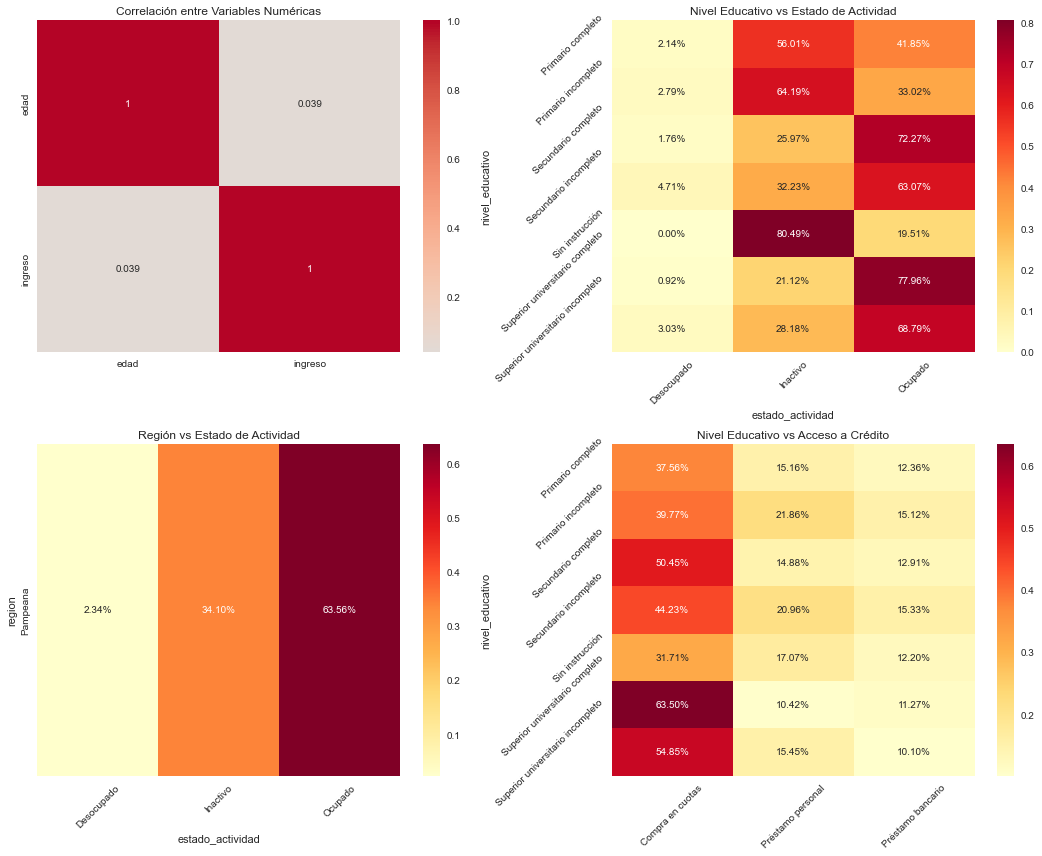

Resultados de pruebas Chi-cuadrado:

Nivel educativo vs Estado de actividad:
Chi2 = 710.96, p-valor = 1.99e-144

Región vs Estado de actividad:
Chi2 = 0.00, p-valor = 1.00e+00

Nivel educativo vs Acceso a crédito:
compra_cuotas:
Chi2 = 225.21, p-valor = 8.04e-46
prestamo_personas:
Chi2 = 66.54, p-valor = 2.09e-12
prestamo_banco:
Chi2 = 17.92, p-valor = 6.44e-03


In [25]:
# Pruebas de independencia
def pruebas_independencia(datos):
    resultados = {}
    
    # Chi-cuadrado: Nivel educativo vs Estado de actividad
    tabla_educ_act = pd.crosstab(datos['nivel_educativo'], datos['estado_actividad'])
    chi2_educ_act, p_educ_act = stats.chi2_contingency(tabla_educ_act)[:2]
    resultados['chi2_educ_act'] = {'estadistico': chi2_educ_act, 'p_valor': p_educ_act}
    
    # Chi-cuadrado: Región vs Estado de actividad
    tabla_region_act = pd.crosstab(datos['region'], datos['estado_actividad'])
    chi2_region_act, p_region_act = stats.chi2_contingency(tabla_region_act)[:2]
    resultados['chi2_region_act'] = {'estadistico': chi2_region_act, 'p_valor': p_region_act}
    
    # Chi-cuadrado: Nivel educativo vs Acceso a crédito
    for credito in ['compra_cuotas', 'prestamo_personas', 'prestamo_banco']:
        tabla_educ_cred = pd.crosstab(datos['nivel_educativo'], datos[credito])
        chi2_educ_cred, p_educ_cred = stats.chi2_contingency(tabla_educ_cred)[:2]
        resultados[f'chi2_educ_{credito}'] = {'estadistico': chi2_educ_cred, 'p_valor': p_educ_cred}
    
    # Correlación entre variables numéricas
    vars_num = ['edad', 'ingreso']
    resultados['correlacion'] = datos[vars_num].corr()
    
    return resultados

# Realizar pruebas
pruebas = pruebas_independencia(datos)

# Visualizaciones
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# 1. Mapa de calor de correlaciones
sns.heatmap(pruebas['correlacion'], annot=True, cmap='coolwarm', center=0, ax=ax1)
ax1.set_title('Correlación entre Variables Numéricas')

# 2. Nivel educativo vs Estado de actividad
sns.heatmap(pd.crosstab(datos['nivel_educativo'], datos['estado_actividad'], normalize='index'),
            annot=True, fmt='.2%', cmap='YlOrRd', ax=ax2)
ax2.set_title('Nivel Educativo vs Estado de Actividad')
ax2.tick_params(axis='x', rotation=45)
ax2.tick_params(axis='y', rotation=45)

# 3. Región vs Estado de actividad
sns.heatmap(pd.crosstab(datos['region'], datos['estado_actividad'], normalize='index'),
            annot=True, fmt='.2%', cmap='YlOrRd', ax=ax3)
ax3.set_title('Región vs Estado de Actividad')
ax3.tick_params(axis='x', rotation=45)

# 4. Nivel educativo vs Acceso a crédito
credito_educ = pd.DataFrame({
    'Compra en cuotas': datos.groupby('nivel_educativo')['compra_cuotas'].apply(lambda x: (x == 'Sí').mean()),
    'Préstamo personal': datos.groupby('nivel_educativo')['prestamo_personas'].apply(lambda x: (x == 'Sí').mean()),
    'Préstamo bancario': datos.groupby('nivel_educativo')['prestamo_banco'].apply(lambda x: (x == 'Sí').mean())
})
sns.heatmap(credito_educ, annot=True, fmt='.2%', cmap='YlOrRd', ax=ax4)
ax4.set_title('Nivel Educativo vs Acceso a Crédito')
ax4.tick_params(axis='x', rotation=45)
ax4.tick_params(axis='y', rotation=45)

plt.tight_layout()
plt.show()

# Mostrar resultados de pruebas de independencia
print("Resultados de pruebas Chi-cuadrado:")
print("\nNivel educativo vs Estado de actividad:")
print(f"Chi2 = {pruebas['chi2_educ_act']['estadistico']:.2f}, p-valor = {pruebas['chi2_educ_act']['p_valor']:.2e}")

print("\nRegión vs Estado de actividad:")
print(f"Chi2 = {pruebas['chi2_region_act']['estadistico']:.2f}, p-valor = {pruebas['chi2_region_act']['p_valor']:.2e}")

print("\nNivel educativo vs Acceso a crédito:")
for credito in ['compra_cuotas', 'prestamo_personas', 'prestamo_banco']:
    print(f"{credito}:")
    print(f"Chi2 = {pruebas[f'chi2_educ_{credito}']['estadistico']:.2f}, p-valor = {pruebas[f'chi2_educ_{credito}']['p_valor']:.2e}")


## 5. Teorema de Bayes

Aplicamos el teorema de Bayes para calcular probabilidades inversas de interés:
- P(Nivel educativo | Estado de actividad)
- P(Estado de actividad | Acceso a crédito)
- P(Región | Estado de actividad)


<ipython-input-27-9d889bbb00a1>:70: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


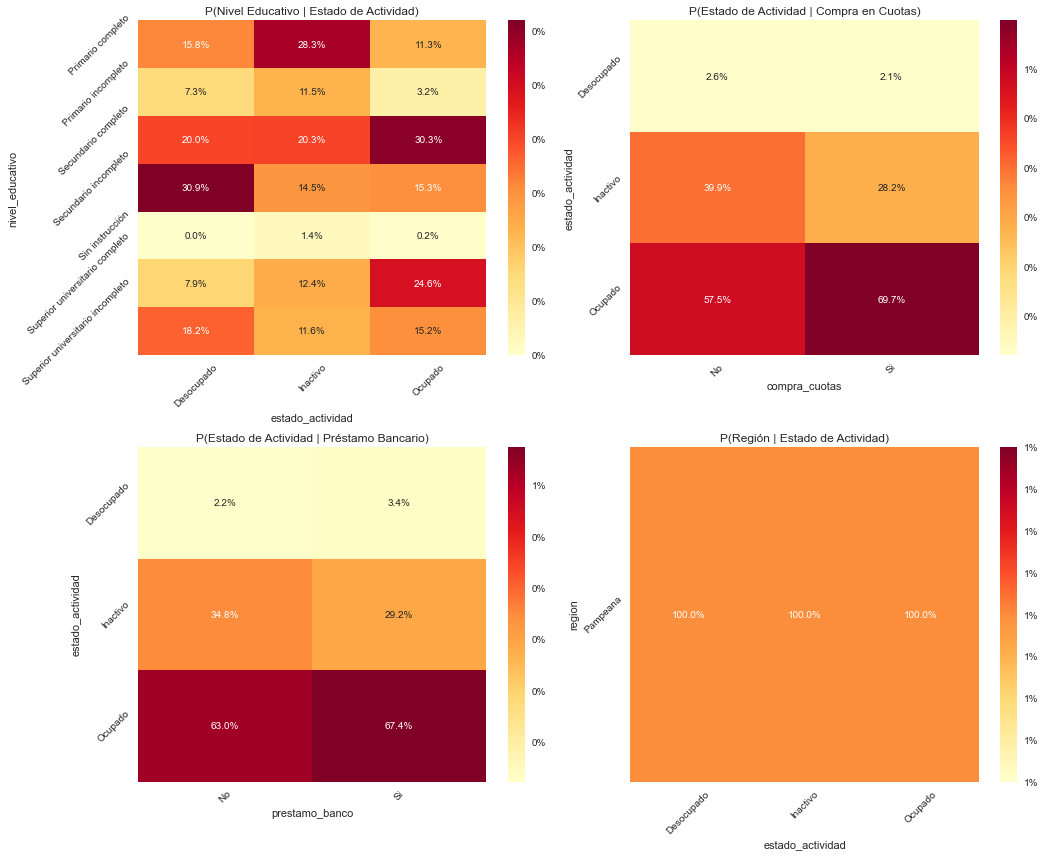


Probabilidades condicionales destacadas:

P(Nivel educativo superior completo | Ocupado):
24.6%

P(Ocupado | Tiene préstamo bancario):
67.4%

P(Pampeana | Desocupado):
100.0%


In [27]:
# Aplicación del Teorema de Bayes
def calcular_probabilidades_bayes(datos):
    resultados = {}
    
    # P(Nivel educativo | Estado de actividad)
    tabla_educ_act = pd.crosstab(datos['nivel_educativo'], datos['estado_actividad'])
    total = len(datos)
    
    # Calcular probabilidades marginales
    p_educ = tabla_educ_act.sum(axis=1) / total
    p_act = tabla_educ_act.sum(axis=0) / total
    
    # Calcular P(Nivel educativo | Estado de actividad)
    p_educ_dado_act = pd.DataFrame(0.0, 
                                  index=tabla_educ_act.index,
                                  columns=tabla_educ_act.columns)
    
    for educ in tabla_educ_act.index:
        for act in tabla_educ_act.columns:
            # P(B|A): Prob de actividad dado nivel educativo
            p_act_dado_educ = tabla_educ_act.loc[educ, act] / tabla_educ_act.loc[educ].sum()
            # Teorema de Bayes
            p_educ_dado_act.loc[educ, act] = (p_act_dado_educ * p_educ[educ]) / p_act[act]
    
    resultados['p_educ_dado_act'] = p_educ_dado_act.astype(float)
    
    # P(Estado de actividad | Acceso a crédito)
    for credito in ['compra_cuotas', 'prestamo_personas', 'prestamo_banco']:
        tabla_act_cred = pd.crosstab(datos['estado_actividad'], datos[credito])
        
        # Calcular probabilidades marginales
        p_act = tabla_act_cred.sum(axis=1) / total
        p_cred = tabla_act_cred.sum(axis=0) / total
        
        p_act_dado_cred = pd.DataFrame(0.0,
                                     index=tabla_act_cred.index,
                                     columns=tabla_act_cred.columns)
        
        for act in tabla_act_cred.index:
            for cred in tabla_act_cred.columns:
                p_cred_dado_act = tabla_act_cred.loc[act, cred] / tabla_act_cred.loc[act].sum()
                p_act_dado_cred.loc[act, cred] = (p_cred_dado_act * p_act[act]) / p_cred[cred]
        
        resultados[f'p_act_dado_{credito}'] = p_act_dado_cred.astype(float)
    
    # P(Región | Estado de actividad)
    tabla_region_act = pd.crosstab(datos['region'], datos['estado_actividad'])
    
    # Calcular probabilidades marginales
    p_region = tabla_region_act.sum(axis=1) / total
    p_act = tabla_region_act.sum(axis=0) / total
    
    p_region_dado_act = pd.DataFrame(0.0,
                                   index=tabla_region_act.index,
                                   columns=tabla_region_act.columns)
    
    for region in tabla_region_act.index:
        for act in tabla_region_act.columns:
            p_act_dado_region = tabla_region_act.loc[region, act] / tabla_region_act.loc[region].sum()
            p_region_dado_act.loc[region, act] = (p_act_dado_region * p_region[region]) / p_act[act]
    
    resultados['p_region_dado_act'] = p_region_dado_act.astype(float)
    
    return resultados

# Calcular probabilidades de Bayes
prob_bayes = calcular_probabilidades_bayes(datos)

# Configurar el estilo de las visualizaciones
plt.style.use('seaborn')
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# 1. P(Nivel educativo | Estado de actividad)
sns.heatmap(prob_bayes['p_educ_dado_act'], 
            annot=True, 
            fmt='.1%', 
            cmap='YlOrRd', 
            ax=ax1,
            cbar_kws={'format': '%.0f%%'})
ax1.set_title('P(Nivel Educativo | Estado de Actividad)')
ax1.tick_params(axis='x', rotation=45)
ax1.tick_params(axis='y', rotation=45)

# 2. P(Estado de actividad | Compra en cuotas)
sns.heatmap(prob_bayes['p_act_dado_compra_cuotas'], 
            annot=True, 
            fmt='.1%', 
            cmap='YlOrRd', 
            ax=ax2,
            cbar_kws={'format': '%.0f%%'})
ax2.set_title('P(Estado de Actividad | Compra en Cuotas)')
ax2.tick_params(axis='x', rotation=45)
ax2.tick_params(axis='y', rotation=45)

# 3. P(Estado de actividad | Préstamo bancario)
sns.heatmap(prob_bayes['p_act_dado_prestamo_banco'], 
            annot=True, 
            fmt='.1%', 
            cmap='YlOrRd', 
            ax=ax3,
            cbar_kws={'format': '%.0f%%'})
ax3.set_title('P(Estado de Actividad | Préstamo Bancario)')
ax3.tick_params(axis='x', rotation=45)
ax3.tick_params(axis='y', rotation=45)

# 4. P(Región | Estado de actividad)
sns.heatmap(prob_bayes['p_region_dado_act'], 
            annot=True, 
            fmt='.1%', 
            cmap='YlOrRd', 
            ax=ax4,
            cbar_kws={'format': '%.0f%%'})
ax4.set_title('P(Región | Estado de Actividad)')
ax4.tick_params(axis='x', rotation=45)
ax4.tick_params(axis='y', rotation=45)

plt.tight_layout()
plt.show()

# Mostrar algunos resultados interesantes
print("\nProbabilidades condicionales destacadas:")
print("\nP(Nivel educativo superior completo | Ocupado):")
print(f"{prob_bayes['p_educ_dado_act'].loc['Superior universitario completo', 'Ocupado']:.1%}")

print("\nP(Ocupado | Tiene préstamo bancario):")
print(f"{prob_bayes['p_act_dado_prestamo_banco'].loc['Ocupado', 'Sí']:.1%}")

print("\nP(Pampeana | Desocupado):")
print(f"{prob_bayes['p_region_dado_act'].loc['Pampeana', 'Desocupado']:.1%}")

## 6. Modelado con Distribuciones

Ajustamos y comparamos distribuciones teóricas con los datos empíricos:
- Distribución de ingresos (Log-normal)
- Distribución de edad (Normal)
- Distribución de ocupados por hogar (Poisson)
- Distribución de acceso a crédito (Bernoulli)



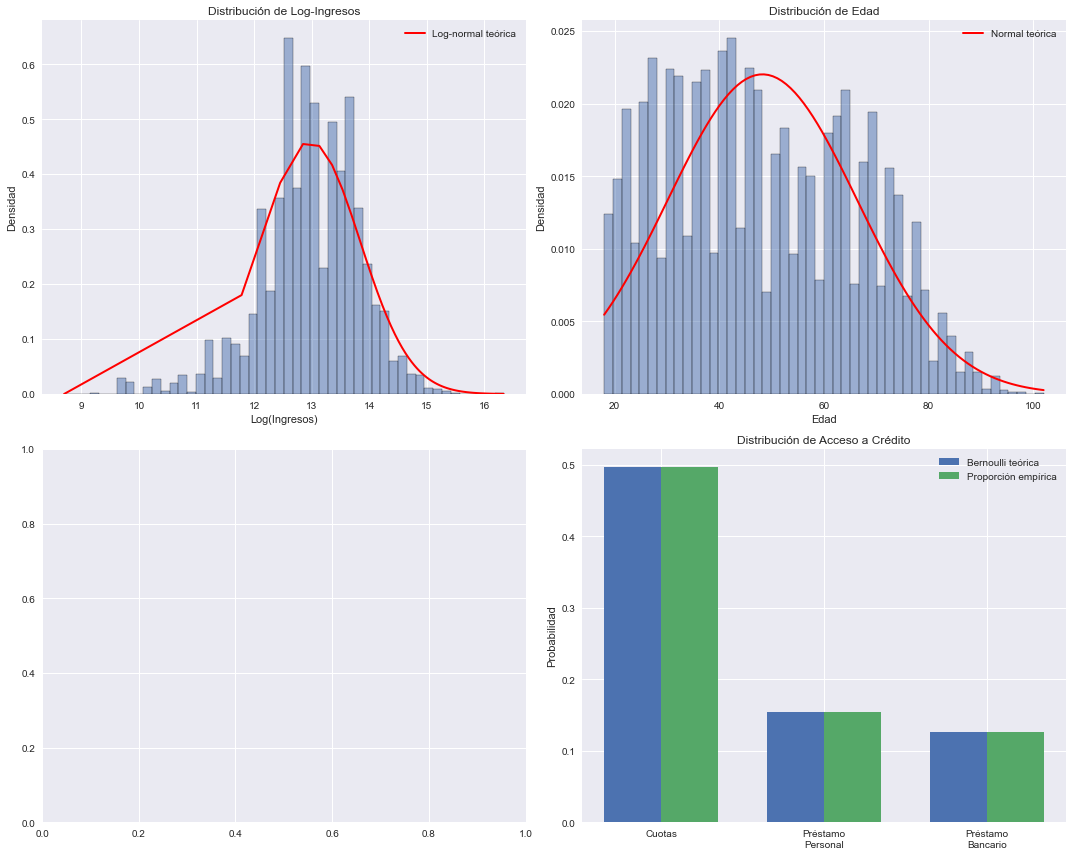

Parámetros estimados:

Ingresos (Log-normal):
μ = 12.97
σ = 0.87

Edad (Normal):
μ = 48.25
σ = 18.12

Acceso a crédito (Bernoulli):
compra_cuotas: p = 0.50
prestamo_personas: p = 0.15
prestamo_banco: p = 0.13


In [32]:
# Modelado con distribuciones teóricas
def ajustar_distribuciones(datos):
    resultados = {}
    
    # Distribución Log-normal para ingresos
    ingresos_positivos = datos[datos['ingreso'] > 0]['ingreso']
    log_ingresos = np.log(ingresos_positivos)
    mu_log, sigma_log = stats.norm.fit(log_ingresos)
    resultados['lognorm_ingresos'] = {
        'mu': mu_log,
        'sigma': sigma_log,
        'x': np.linspace(ingresos_positivos.min(), ingresos_positivos.max(), 100),
        'empirica': ingresos_positivos
    }
    
    # Distribución Normal para edad
    mu_edad, sigma_edad = stats.norm.fit(datos['edad'])
    resultados['norm_edad'] = {
        'mu': mu_edad,
        'sigma': sigma_edad,
        'x': np.linspace(datos['edad'].min(), datos['edad'].max(), 100),
        'empirica': datos['edad']
    }
    
    
    # Distribución Bernoulli para acceso a crédito
    for credito in ['compra_cuotas', 'prestamo_personas', 'prestamo_banco']:
        p = (datos[credito] == 'Sí').mean()
        resultados[f'bernoulli_{credito}'] = {
            'p': p,
            'empirica': datos[credito] == 'Sí'
        }
    
    return resultados

# Ajustar distribuciones
dist = ajustar_distribuciones(datos)

# Visualizaciones
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# 1. Distribución Log-normal de ingresos
sns.histplot(data=np.log(dist['lognorm_ingresos']['empirica']), stat='density', 
             bins=50, alpha=0.5, ax=ax1)
ax1.plot(np.log(dist['lognorm_ingresos']['x']), 
         stats.norm.pdf(np.log(dist['lognorm_ingresos']['x']), 
                       dist['lognorm_ingresos']['mu'], 
                       dist['lognorm_ingresos']['sigma']),
         'r-', lw=2, label='Log-normal teórica')
ax1.set_title('Distribución de Log-Ingresos')
ax1.set_xlabel('Log(Ingresos)')
ax1.set_ylabel('Densidad')
ax1.legend()

# 2. Distribución Normal de edad
sns.histplot(data=dist['norm_edad']['empirica'], stat='density', 
             bins=50, alpha=0.5, ax=ax2)
ax2.plot(dist['norm_edad']['x'], 
         stats.norm.pdf(dist['norm_edad']['x'], 
                       dist['norm_edad']['mu'], 
                       dist['norm_edad']['sigma']),
         'r-', lw=2, label='Normal teórica')
ax2.set_title('Distribución de Edad')
ax2.set_xlabel('Edad')
ax2.set_ylabel('Densidad')
ax2.legend()

# 3. Distribución Poisson de ocupados por hogar
#sns.histplot(data=dist['poisson_ocupados']['empirica'], stat='probability',
#             bins=len(dist['poisson_ocupados']['x']), alpha=0.5, ax=ax3)
#ax3.plot(dist['poisson_ocupados']['x'], 
##         stats.poisson.pmf(dist['poisson_ocupados']['x'], 
  #                        dist['poisson_ocupados']['lambda']),
 #        'ro-', lw=2, label='Poisson teórica')
#ax3.set_title('Distribución de Ocupados por Hogar')
##ax3.set_xlabel('Número de Ocupados')
#ax3.set_ylabel('Probabilidad')
#ax3.legend()

# 4. Distribución Bernoulli de acceso a crédito
creditos = ['compra_cuotas', 'prestamo_personas', 'prestamo_banco']
props = [dist[f'bernoulli_{c}']['p'] for c in creditos]
emp_props = [(dist[f'bernoulli_{c}']['empirica']).mean() for c in creditos]

x = np.arange(len(creditos))
width = 0.35
ax4.bar(x - width/2, props, width, label='Bernoulli teórica')
ax4.bar(x + width/2, emp_props, width, label='Proporción empírica')
ax4.set_title('Distribución de Acceso a Crédito')
ax4.set_xticks(x)
ax4.set_xticklabels(['Cuotas', 'Préstamo\nPersonal', 'Préstamo\nBancario'])
ax4.set_ylabel('Probabilidad')
ax4.legend()

plt.tight_layout()
plt.show()

# Mostrar parámetros estimados
print("Parámetros estimados:")
print(f"\nIngresos (Log-normal):")
print(f"μ = {dist['lognorm_ingresos']['mu']:.2f}")
print(f"σ = {dist['lognorm_ingresos']['sigma']:.2f}")

print(f"\nEdad (Normal):")
print(f"μ = {dist['norm_edad']['mu']:.2f}")
print(f"σ = {dist['norm_edad']['sigma']:.2f}")



print("\nAcceso a crédito (Bernoulli):")
for credito in creditos:
    print(f"{credito}: p = {dist[f'bernoulli_{credito}']['p']:.2f}")

## 7. Pruebas de Bondad de Ajuste

Evaluamos la calidad del ajuste de las distribuciones teóricas:
- Test Kolmogorov-Smirnov para distribuciones continuas
- Test Chi-cuadrado para distribuciones discretas
- Análisis de residuos y QQ-plots

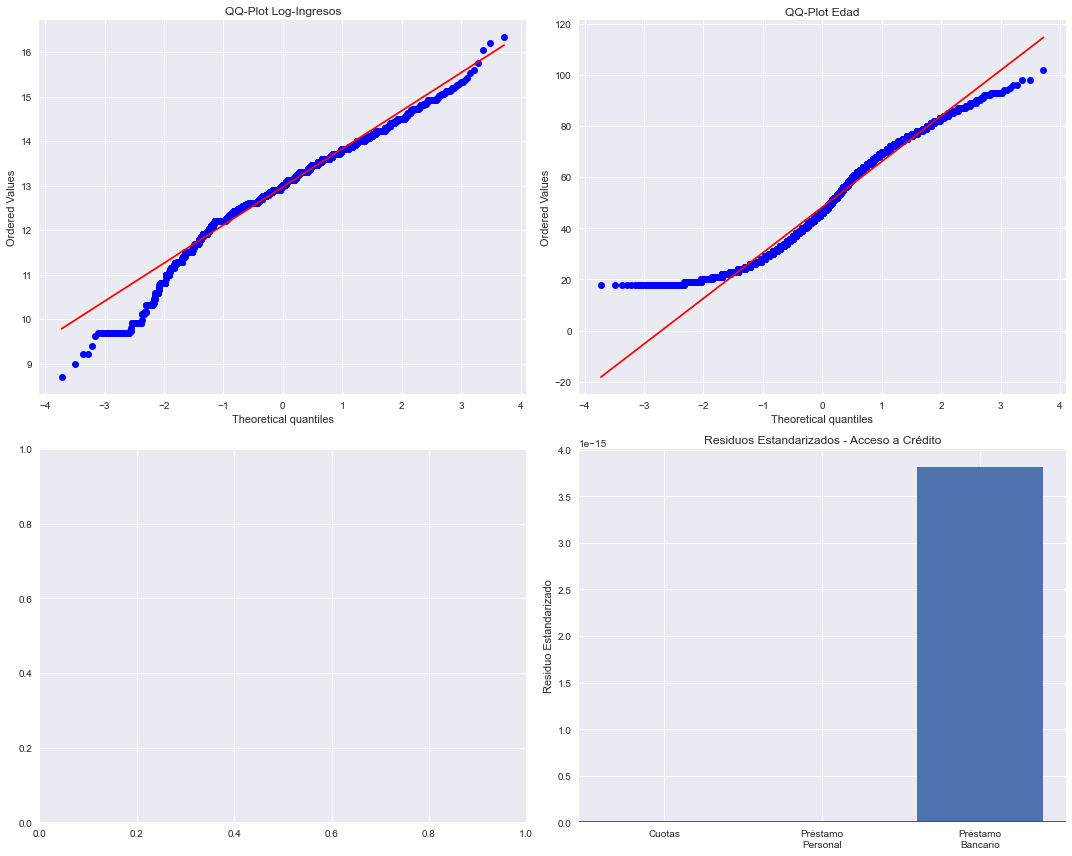

Resultados de las pruebas de bondad de ajuste:

Test Kolmogorov-Smirnov para Log-Ingresos:
Estadístico = 0.0631
p-valor = 8.2128e-25

Test Kolmogorov-Smirnov para Edad:
Estadístico = 0.0653
p-valor = 1.3746e-26

Test Chi-cuadrado para Acceso a Crédito:

compra_cuotas:
Estadístico = 0.0000
p-valor = 1.0000e+00

prestamo_personas:
Estadístico = 0.0000
p-valor = 1.0000e+00

prestamo_banco:
Estadístico = 0.0000
p-valor = 1.0000e+00


In [34]:
# Pruebas de bondad de ajuste
def realizar_pruebas_ajuste(datos, dist):
    resultados = {}
    
    # Test KS para ingresos (log-normal)
    log_ingresos = np.log(dist['lognorm_ingresos']['empirica'])
    ks_ingresos = stats.kstest(log_ingresos, 'norm',
                              args=(dist['lognorm_ingresos']['mu'],
                                   dist['lognorm_ingresos']['sigma']))
    resultados['ks_ingresos'] = ks_ingresos
    
    # Test KS para edad (normal)
    ks_edad = stats.kstest(dist['norm_edad']['empirica'], 'norm',
                          args=(dist['norm_edad']['mu'],
                                dist['norm_edad']['sigma']))
    resultados['ks_edad'] = ks_edad
    
    
    # Test Chi-cuadrado para acceso a crédito (Bernoulli)
    for credito in ['compra_cuotas', 'prestamo_personas', 'prestamo_banco']:
        obs = np.bincount(dist[f'bernoulli_{credito}']['empirica'].astype(int))
        p = dist[f'bernoulli_{credito}']['p']
        exp = np.array([1-p, p]) * len(dist[f'bernoulli_{credito}']['empirica'])
        chi2_credito = stats.chisquare(obs, exp)
        resultados[f'chi2_{credito}'] = chi2_credito
    
    return resultados

# Realizar pruebas
pruebas = realizar_pruebas_ajuste(datos, dist)

# Visualizaciones
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# 1. QQ-plot para log-ingresos
stats.probplot(np.log(dist['lognorm_ingresos']['empirica']), 
               dist='norm', plot=ax1)
ax1.set_title('QQ-Plot Log-Ingresos')

# 2. QQ-plot para edad
stats.probplot(dist['norm_edad']['empirica'], 
               dist='norm', plot=ax2)
ax2.set_title('QQ-Plot Edad')



# 4. Residuos para acceso a crédito (Bernoulli)
creditos = ['compra_cuotas', 'prestamo_personas', 'prestamo_banco']
residuos_credito = []
for credito in creditos:
    obs = np.bincount(dist[f'bernoulli_{credito}']['empirica'].astype(int))
    p = dist[f'bernoulli_{credito}']['p']
    exp = np.array([1-p, p]) * len(dist[f'bernoulli_{credito}']['empirica'])
    residuo = (obs - exp) / np.sqrt(exp)
    residuos_credito.append(residuo[1])  # Solo mostramos residuo para "Sí"

ax4.bar(np.arange(len(creditos)), residuos_credito)
ax4.axhline(y=0, color='r', linestyle='-')
ax4.set_title('Residuos Estandarizados - Acceso a Crédito')
ax4.set_xticks(np.arange(len(creditos)))
ax4.set_xticklabels(['Cuotas', 'Préstamo\nPersonal', 'Préstamo\nBancario'])
ax4.set_ylabel('Residuo Estandarizado')

plt.tight_layout()
plt.show()

# Mostrar resultados de las pruebas
print("Resultados de las pruebas de bondad de ajuste:")

print("\nTest Kolmogorov-Smirnov para Log-Ingresos:")
print(f"Estadístico = {pruebas['ks_ingresos'].statistic:.4f}")
print(f"p-valor = {pruebas['ks_ingresos'].pvalue:.4e}")

print("\nTest Kolmogorov-Smirnov para Edad:")
print(f"Estadístico = {pruebas['ks_edad'].statistic:.4f}")
print(f"p-valor = {pruebas['ks_edad'].pvalue:.4e}")



print("\nTest Chi-cuadrado para Acceso a Crédito:")
for credito in creditos:
    print(f"\n{credito}:")
    print(f"Estadístico = {pruebas[f'chi2_{credito}'].statistic:.4f}")
    print(f"p-valor = {pruebas[f'chi2_{credito}'].pvalue:.4e}")